In [1]:
!pip install grad-cam opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s et

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cnn_cifar10.pth to cnn_cifar10.pth


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Misclassified example:


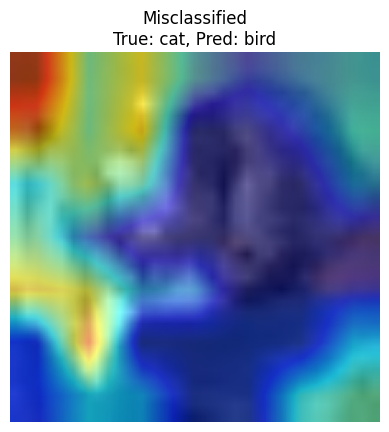

Correctly classified example:


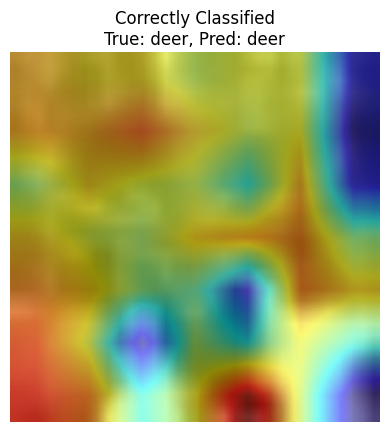

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define transforms for model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 3. Load test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 4. Load trained model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load("cnn_cifar10.pth", map_location=device))
model.to(device)
model.eval()

# 5. Grad-CAM setup
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 6. Helper function to run CAM and plot
correct_img = None
misclassified_img = None

def generate_and_plot_cam(inputs, raw_img, target_class, predicted_class, title):
    grayscale_cam = cam(input_tensor=inputs, targets=[ClassifierOutputTarget(target_class)])[0]
    visualization = show_cam_on_image(raw_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"{title}\nTrue: {classes[target_class]}, Pred: {classes[predicted_class]}")
    plt.axis('off')
    plt.show()

# 7. Loop to find and visualize correct and incorrect predictions
for idx, (inputs, labels) in enumerate(testloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Get normalized image for CAM overlay
    unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))],
        std=[1/s for s in (0.2023, 0.1994, 0.2010)]
    )
    raw_img = unnormalize(inputs[0].cpu()).permute(1, 2, 0).numpy()
    raw_img = np.clip(raw_img, 0, 1)

    if preds == labels and correct_img is None:
        print("Correctly classified example:")
        generate_and_plot_cam(inputs, raw_img, labels.item(), preds.item(), "Correctly Classified")
        correct_img = True

    if preds != labels and misclassified_img is None:
        print("Misclassified example:")
        generate_and_plot_cam(inputs, raw_img, labels.item(), preds.item(), "Misclassified")
        misclassified_img = True

    if correct_img == True and misclassified_img == True:
        break


Device: cpu


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


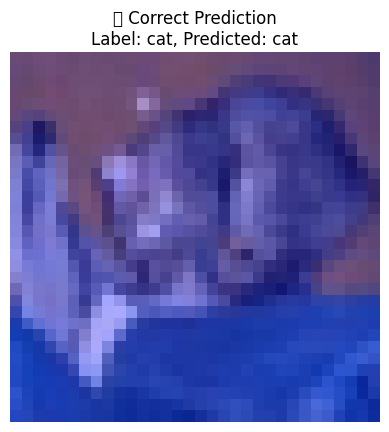

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


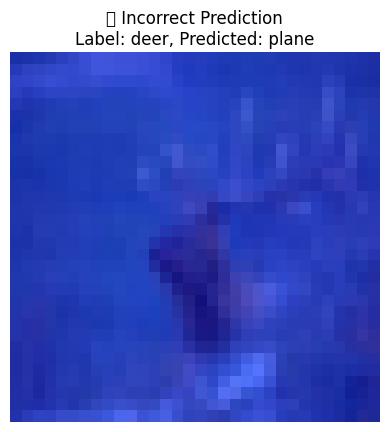

In [8]:
!pip install grad-cam --quiet

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transform for ResNet-18
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

# Load CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Load trained ResNet-18 model
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load("cnn_cifar10.pth", map_location=device))
model.to(device).eval()

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Try to find one correct and one incorrect prediction
found_correct = found_incorrect = False
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    is_correct = (predicted == labels).item()

    # Prepare GradCAM
    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=inputs, targets=[ClassifierOutputTarget(predicted.item())])[0]

    # Unnormalize image for visualization
    image_np = inputs.squeeze().cpu().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))
    image_np = image_np * [0.2023, 0.1994, 0.2010] + [0.4914, 0.4822, 0.4465]
    image_np = np.clip(image_np, 0, 1)

    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    # Show result
    plt.imshow(cam_image)
    label_text = f"Label: {classes[labels.item()]}, Predicted: {classes[predicted.item()]}"
    if is_correct and not found_correct:
        plt.title(f"✅ Correct Prediction\n{label_text}")
        found_correct = True
    elif not is_correct and not found_incorrect:
        plt.title(f"❌ Incorrect Prediction\n{label_text}")
        found_incorrect = True
    else:
        continue

    plt.axis("off")
    plt.show()

    if found_correct and found_incorrect:
        break
